In [51]:
# Modules
from qiskit.quantum_info import Pauli, SparsePauliOp
from itertools import combinations
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
import numpy as np
from scipy.optimize import minimize
from functools import reduce


In [77]:
# Les valeurs / exemples
#n = 3  n_qubits = P_i, un seul générateur → P_i qubits
q=2 #bits par générateur 
P_i   = [3,2]          # granularité (3 qubits)
c_i   = [10,8]       # coût linéaire
D_i   = [30,20]        # demande par noeud
D_tot=np.sum(D_i)


Je définis l’ordre :

- Tous les xij d’abord, dans l’ordre de L : index 0, 1, ...

- Puis tous les $\beta$​ par ordre (i, s, m) : index 2, 3, ...

In [ ]:
#alpha_m=[1,1,1,0,1,0,1,0]  j'ai pensé à éliminer tous les termes contenant 0 dans la liste -->  je garde que les 1, je fais un dict pour associer le 1 à sa position
liste = list(range(q))

alpha_m=[0,1,2,4,6] # Pour représenter 360 degrés
x_vars = [(i, j) for i in range(q) for j in range(i+1, q)]
beta_vars = [(i, s, m) for i in liste for m in range(5) for s in range(m+1, 5)] # beta_sm=beta_ms ?????
all = x_vars + beta_vars
qubit_index = {f"x_{i}_{j}": idx for idx, (i,j) in enumerate(x_vars)}
offset = len(x_vars)
for k, (i,s,m) in enumerate(beta_vars):
    qubit_index[f"beta_{i}_{s}_{m}"] = offset + k

n_qubit = len(all)
print(len(beta_vars))



20


In [83]:
#Pour coder les index
def idx_x(i, j):
    return qubit_index[f"x_{i}_{j}"]

def idx_beta(i, s, m):
    return qubit_index[f"beta_{i}_{s}_{m}"]# Préparation


In [80]:
terms = []
B_ij = {(0,1): 1.0 }


# Construction
for i in range(q):
    for j in range(i+1, q):
        if j!= i:
            for m in range(5):
                for s in range(m+1, 5):
                    coeff = c_i[i] * B_ij[(i,j)] *1 * (2**alpha_m[s]) / 4 # Le 1 pour rempacer alpha_m[m]

                    x_idx = idx_x(i,j)
                    b_i_idx = idx_beta(i,s,m)
                    b_j_idx = idx_beta(j,s,m)

                    # Zx * Zbeta_j : -coeff
                    pauli = ['I'] * n_qubit
                    pauli[x_idx] = 'Z'
                    pauli[b_j_idx] = 'Z'
                    terms.append((''.join(pauli), -coeff))

                    # Zx * Zbeta_i : +coeff
                    pauli = ['I'] * n_qubit
                    pauli[x_idx] = 'Z'
                    pauli[b_i_idx] = 'Z'
                    terms.append((''.join(pauli), coeff))

                    # Zbeta_j : +coeff
                    pauli = ['I'] * n_qubit
                    pauli[b_j_idx] = 'Z'
                    terms.append((''.join(pauli), coeff))

                    # Zbeta_i : -coeff
                    pauli = ['I'] * n_qubit
                    pauli[b_i_idx] = 'Z'
                    terms.append((''.join(pauli), -coeff))
                    

# Terme constant D_i
pauli = 'I' * n_qubit
terms.append((pauli, c_i[i] * D_i[i]))

H1 = SparsePauliOp.from_list(terms)
print(H1)


SparsePauliOp(['ZIIIIIIIIIIZIIIIIIIII', 'ZZIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIZIIIIIIIII', 'IZIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIZIIIIIIII', 'ZIZIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIZIIIIIIII', 'IIZIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIZIIIIIII', 'ZIIZIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIZIIIIIII', 'IIIZIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIZIIIIII', 'ZIIIZIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZIIIIII', 'IIIIZIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIIZIIIII', 'ZIIIIZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIZIIIII', 'IIIIIZIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIIIZIIII', 'ZIIIIIZIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIZIIII', 'IIIIIIZIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIIIIZIII', 'ZIIIIIIZIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIZIII', 'IIIIIIIZIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIIIIIZII', 'ZIIIIIIIZIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIZII', 'IIIIIIIIZIIIIIIIIIIII', 'ZIIIIIIIIIIIIIIIIIIZI', 'ZIIIIIIIIZIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIZIIIIIIIIIII', 'ZIIIIIIIIIIIIIIIIIIIZ', 'ZIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIII

In [ ]:
from qiskit.circuit.library import PauliEvolutionGate
def U_C(gamma, H):
    gate = PauliEvolutionGate(H, time=gamma)
    return gate.definition 

def U_M(beta, H):
    gate = PauliEvolutionGate(H, time=beta)
    return gate.definition


In [57]:
#Définition de L'Hamiltonien de mélange
from qiskit.quantum_info import SparsePauliOp

H_M2 = SparsePauliOp.from_list([
    ('I'*i + 'X' + 'I'*(n_qubit-i-1), 1.0)
    for i in range(n_qubit)
])

print(H_M2)


SparsePauliOp(['XIIIIIIIIIIIIIIIIIIII', 'IXIIIIIIIIIIIIIIIIIII', 'IIXIIIIIIIIIIIIIIIIII', 'IIIXIIIIIIIIIIIIIIIII', 'IIIIXIIIIIIIIIIIIIIII', 'IIIIIXIIIIIIIIIIIIIII', 'IIIIIIXIIIIIIIIIIIIII', 'IIIIIIIXIIIIIIIIIIIII', 'IIIIIIIIXIIIIIIIIIIII', 'IIIIIIIIIXIIIIIIIIIII', 'IIIIIIIIIIXIIIIIIIIII', 'IIIIIIIIIIIXIIIIIIIII', 'IIIIIIIIIIIIXIIIIIIII', 'IIIIIIIIIIIIIXIIIIIII', 'IIIIIIIIIIIIIIXIIIIII', 'IIIIIIIIIIIIIIIXIIIII', 'IIIIIIIIIIIIIIIIXIIII', 'IIIIIIIIIIIIIIIIIXIII', 'IIIIIIIIIIIIIIIIIIXII', 'IIIIIIIIIIIIIIIIIIIXI', 'IIIIIIIIIIIIIIIIIIIIX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j])


In [ ]:
from qiskit import QuantumCircuit

def build_qaoa_circuit(n, p, gammas, betas, cost_h, mixer_h):
    qc = QuantumCircuit(n)  
    qc.h(range(n))          
    
    for layer in range(p):
        qc.append(U_C(float(gammas[layer]), cost_h), range(n))
        qc.append(U_M(float(betas[layer]), mixer_h), range(n))
    
    return qc 


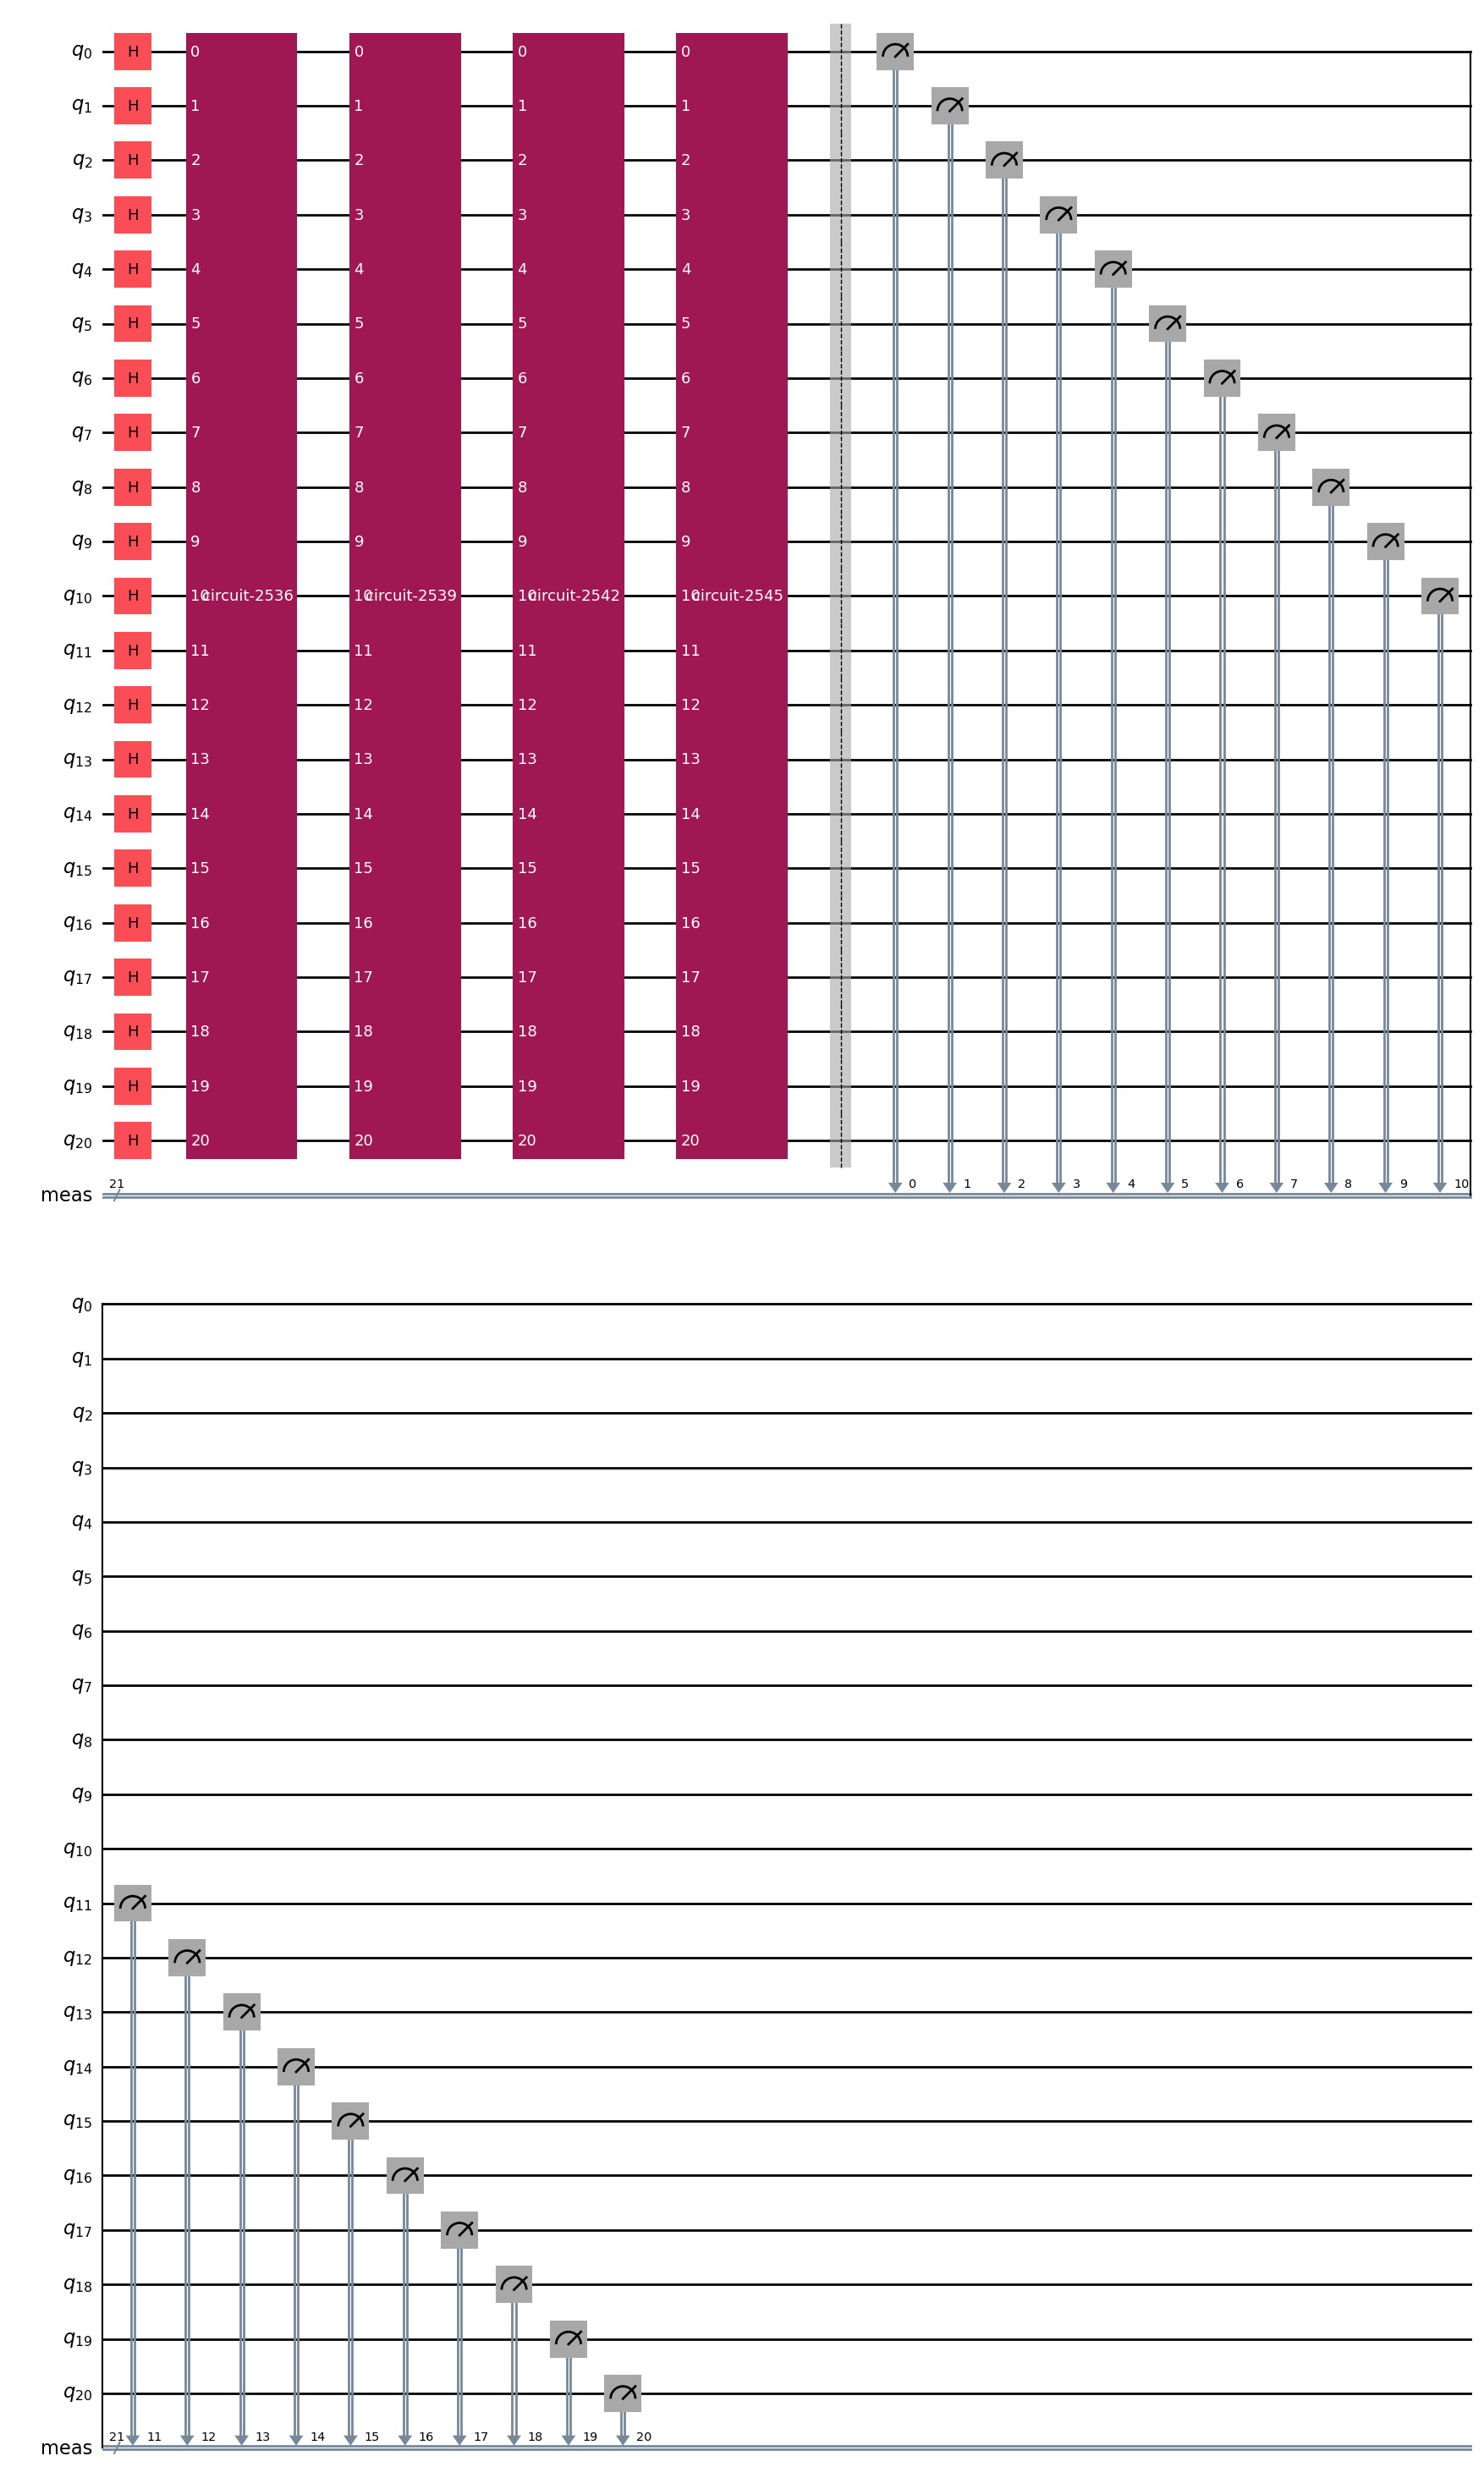

In [ ]:
import pylatexenc
p=2
gammas=[np.pi/4, np.pi/2]
betas=[np.pi/8, np.pi/4]
params=[np.pi/4, np.pi/2, np.pi/8, np.pi/4 ]
cost_h=H1
mixer_h=H_M2
qc2=build_qaoa_circuit(n_qubit,p,gammas,betas,cost_h,mixer_h)
qc2.measure_all()
qc2.draw("mpl")




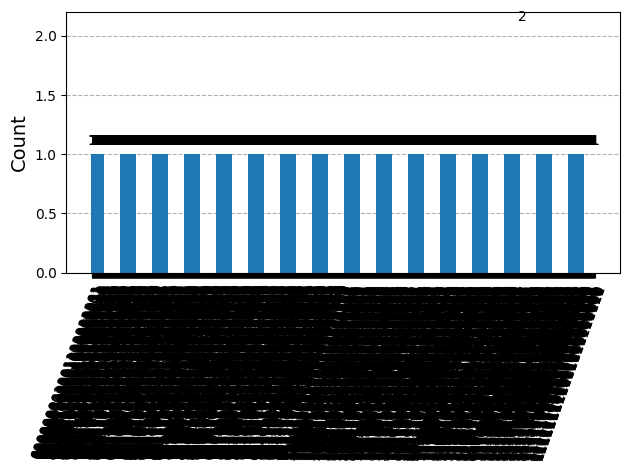

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator  
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

qc_transpiled2 = transpile(qc2, AerSimulator())

job = AerSimulator().run(qc_transpiled2, shots=1024)
result = job.result()
counts = result.get_counts()

plot_histogram(counts)


In [ ]:
from qiskit import transpile
from qiskit_aer import Aer
import numpy as np
from scipy.optimize import minimize

backend = Aer.get_backend('aer_simulator')

def qaoa_expectation(params):
    p = 2
    gammas = params[:p]
    betas = params[p:]
    
    qc2 = build_qaoa_circuit(n_qubit, p, gammas, betas, H1, H_M2)
    qc2.save_statevector()
    
    qc_transpiled = transpile(qc2, backend)
    result = backend.run(qc_transpiled).result()
    
    sv = result.data(0)['statevector']
    expval = sv.expectation_value(H1)
    return -np.real(expval)  # on maximise le coût en minimisant l'opposé




In [62]:

result = minimize(qaoa_expectation, params, method='COBYLA')

print("Paramètres optimaux :", result.x)
print("Espérance d'énergie minimale :", -result.fun)


Paramètres optimaux : [0.64897781 1.2972384  0.1875998  0.59019369]
Espérance d'énergie minimale : 1017.3692663116094


In [65]:
# Récupérer le bitstring le plus probable après exécution
best_bitstring = max(counts, key=counts.get)
print("Bitstring le plus probable :", best_bitstring)
print("Nombre d'occurrences :", counts[best_bitstring])


Bitstring le plus probable : 110111011101000110110
Nombre d'occurrences : 2
